# TOPIC ANALYSIS


## Import Packages

In [1]:
#!pip install simpletransformers

In [2]:
#pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 

## Data Exploration

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
test = pd.read_csv('sentiment-topic-final-test.tsv', sep = '\t')

In [24]:
test['topic'].tolist()

['movie',
 'restaurant',
 'restaurant',
 'book',
 'movie',
 'movie',
 'restaurant',
 'movie',
 'movie',
 'book']

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence id  10 non-null     int64 
 1   text         10 non-null     object
 2   sentiment    10 non-null     object
 3   labels       10 non-null     int64 
 4   predicted    10 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 528.0+ bytes


In [36]:
test.rename(columns = {'topic':'labels'}, inplace = True) #making sure test data matches training data

In [37]:
test['labels'].replace(['movie', 'restaurant', 'book'],
                        [0, 1, 2], inplace=True)

In [7]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['rec.autos', 'rec.motorcycles', 'talk.politics.mideast', 'comp.windows.x'] 

# remove the headers, footers and quotes (to avoid overfitting)
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [8]:
train = pd.DataFrame({'text': train.data, 'labels': train.target})

In [9]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [10]:
train.head()

,text,labels
1930,\nSuggest McQuires #1 plastic polish. It will...,2
2140,\n\t\t\t ^^^^^^^^^^^^^^^^^^^^^^^^^^^\nBeca...,2
739,While I cannot answer questions about running ...,0
1039,"If I have one thing to say about ""No Fault"" it...",2
1161,Will there be any support for round or circula...,0


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 1930 to 1350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2114 non-null   object
 1   labels  2114 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 49.5+ KB


## Creating  and Running Model

In [11]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [12]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch)) # 64 steps = validating 2 times per epoch

Each epoch will have 67 steps.


In [13]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=4, args=model_args, use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [14]:
print(str(model.args).replace(',', '\n')) # model args

ClassificationArgs(adafactor_beta1=None
 adafactor_clip_threshold=1.0
 adafactor_decay_rate=-0.8
 adafactor_eps=(1e-30
 0.001)
 adafactor_relative_step=True
 adafactor_scale_parameter=True
 adafactor_warmup_init=True
 adam_betas=(0.9
 0.999)
 adam_epsilon=1e-08
 best_model_dir='outputs/best_model'
 cache_dir='cache_dir/'
 config={}
 cosine_schedule_num_cycles=0.5
 custom_layer_parameters=[]
 custom_parameter_groups=[]
 dataloader_num_workers=0
 do_lower_case=False
 dynamic_quantize=False
 early_stopping_consider_epochs=False
 early_stopping_delta=0.01
 early_stopping_metric='eval_loss'
 early_stopping_metric_minimize=True
 early_stopping_patience=2
 encoding=None
 eval_batch_size=8
 evaluate_during_training=True
 evaluate_during_training_silent=True
 evaluate_during_training_steps=32
 evaluate_during_training_verbose=False
 evaluate_each_epoch=True
 fp16=False
 gradient_accumulation_steps=1
 learning_rate=4e-06
 local_rank=-1
 logging_steps=50
 loss_type=None
 loss_args={}
 manual_seed

In [15]:
%%time
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/2114 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Wall time: 7h 51min 50s


## Evaluating results

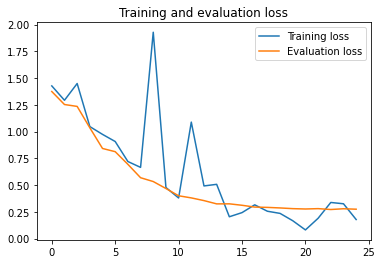

In [16]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [17]:
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/235 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

{'mcc': 0.8714767009386919, 'eval_loss': 0.27507093685368694}

In [38]:
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.67      0.80         3
           2       0.17      0.50      0.25         2
           3       0.00      0.00      0.00         0

    accuracy                           0.30        10
   macro avg       0.29      0.29      0.26        10
weighted avg       0.33      0.30      0.29        10



C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\angel\anaconda3\lib\site-packages\sklearn\metrics\_cla